In [1]:
import initialise as init

In [2]:
adm2_json = init.gpd.read_file('simplified_australia_gadm2.json')
latency_data = init.pd.read_csv('latency_dataset.csv')

In [3]:
print(len(adm2_json))
print(adm2_json)
adm2_json['Mean Latency'] = None
adm2_json['Sum Latency'] = None
adm2_json['Sum Variance'] = None
adm2_json['Mean Variance'] = None
adm2_json['Count'] = None

1386
       fid   gid  id_0  iso     name_0  id_1                        name_1  \
0        1  2598    14  AUS  Australia     2  Australian Capital Territory   
1        2  2599    14  AUS  Australia     2  Australian Capital Territory   
2        3  2600    14  AUS  Australia     2  Australian Capital Territory   
3        4  2601    14  AUS  Australia     2  Australian Capital Territory   
4        5  2602    14  AUS  Australia     2  Australian Capital Territory   
...    ...   ...   ...  ...        ...   ...                           ...   
1381  1382  3987    14  AUS  Australia    11             Western Australia   
1382  1383  3988    14  AUS  Australia    11             Western Australia   
1383  1384  3989    14  AUS  Australia    11             Western Australia   
1384  1385  3990    14  AUS  Australia    11             Western Australia   
1385  1386  3991    14  AUS  Australia    11             Western Australia   

      id_2                  name_2  \
0        2          

In [4]:
print(len(latency_data))
print(latency_data.columns)
print(latency_data)

1386854
Index(['time_e', 'time_e_utc_str', 'adm2_unique_identifier',
       'number_unique_active_ips_in_sample', 'rtt_variance_norm',
       'rtt_mean_norm', 'day_indicator', 'country_iso_three_char_code',
       'country_iso_name', 'adm1_name', 'adm1_unique_identifier', 'adm2_name',
       'timezone_offset', 'timezone_name', 'time_local',
       'number_unique_active_ips_in_sample_log2',
       'number_unique_active_ips_in_sample_log2_adj', 'rtt_mean_norm_adj',
       'number_unique_active_ips_in_sample_adj', 'do_anomaly_module'],
      dtype='object')
             time_e        time_e_utc_str adm2_unique_identifier  \
0        1704078000  01-Jan-2024 03:00:00            AUS-10-1047   
1        1704078000  01-Jan-2024 03:00:00            AUS-10-1048   
2        1704078000  01-Jan-2024 03:00:00            AUS-10-1049   
3        1704078000  01-Jan-2024 03:00:00            AUS-10-1051   
4        1704078000  01-Jan-2024 03:00:00            AUS-10-1052   
...             ...            

In [56]:
print(len(adm2_json['name_2'].unique()))
print(len(latency_data['adm2_name'].unique()))

1365
821


In [5]:
for i in init.tqdm(range(len(adm2_json[1:]))):
    if adm2_json.iloc[i]['name_1'] == adm2_json.iloc[i-1]['name_1']:
        continue
    else:
        print(F"New State: {adm2_json.iloc[i]['name_1']}, {i}")

  0%|          | 0/1385 [00:00<?, ?it/s]

New State: Australian Capital Territory, 0
New State: New South Wales, 110


 28%|██▊       | 385/1385 [00:00<00:00, 1956.20it/s]

New State: Northern Territory, 308


 42%|████▏     | 581/1385 [00:00<00:00, 1939.01it/s]

New State: Queensland, 403


 86%|████████▋ | 1198/1385 [00:00<00:00, 1999.62it/s]

New State: South Australia, 874
New State: Tasmania, 1001
New State: Victoria, 1038
New State: Western Australia, 1246


100%|██████████| 1385/1385 [00:00<00:00, 1983.05it/s]


C:\Users\43472\AppData\Local\Temp\ipykernel_18932\1304946938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restricted_data['timestamp'] = init.pd.to_datetime(restricted_data['time_local'])
C:\Users\43472\AppData\Local\Temp\ipykernel_18932\1304946938.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restricted_data['day_of_week'] = restricted_data['timestamp'].dt.day_name()
C:\Users\43472\AppData\Local\Temp\ipykernel_18932\1304946938.py:9: SettingWithCopyWarning: 
A value is trying to be set on a cop

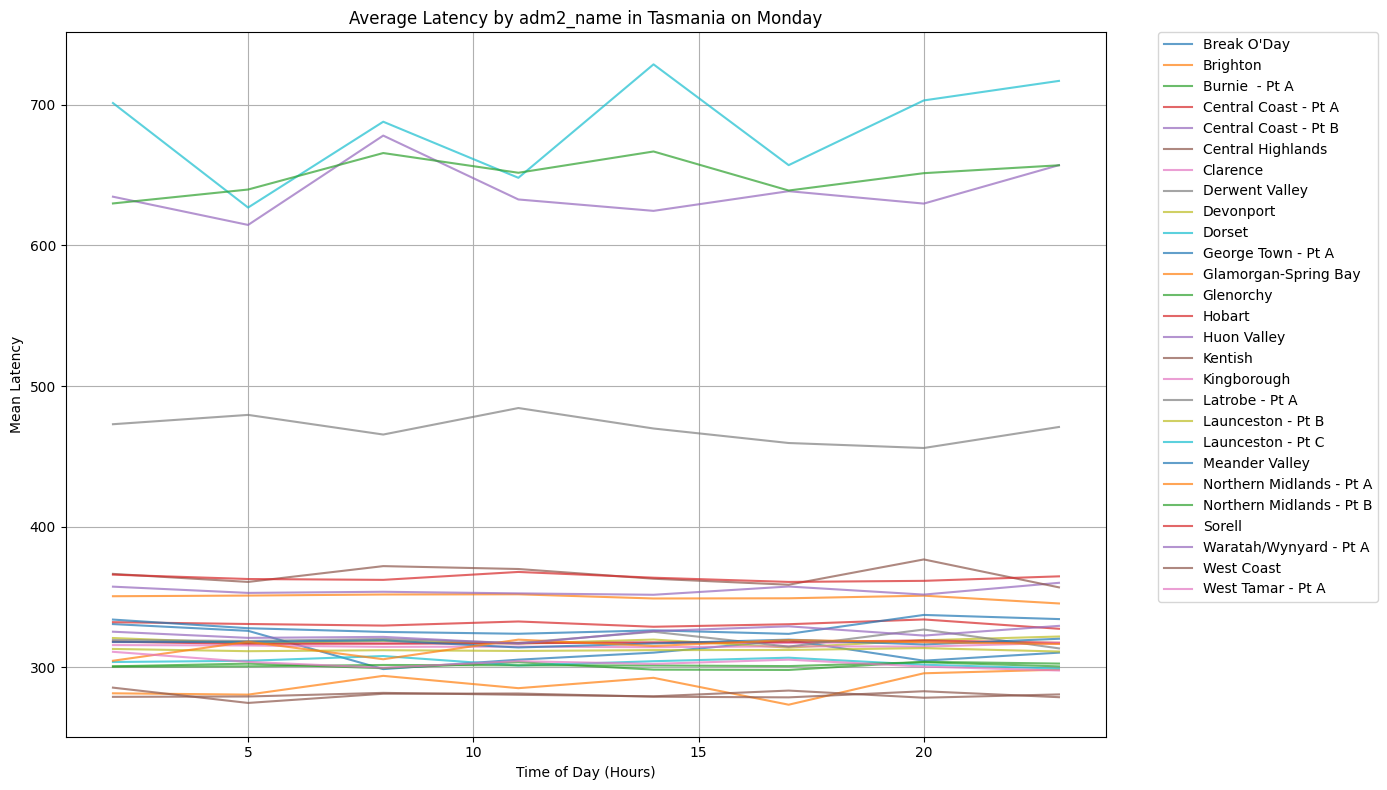

In [6]:
# Create the restricted DataFrame
restricted_data = latency_data[latency_data['number_unique_active_ips_in_sample'] >= 10]

# Ensure the timestamp column is in datetime format
restricted_data['timestamp'] = init.pd.to_datetime(restricted_data['time_local'])

# Extract day of week and time of day
restricted_data['day_of_week'] = restricted_data['timestamp'].dt.day_name()
restricted_data['time_of_day'] = restricted_data['timestamp'].dt.hour + restricted_data['timestamp'].dt.minute / 60

def plot_state_adm2_latency(state_name, day_name):
    # Filter data for the specific state and day
    state_data = init.pd.DataFrame(restricted_data)  # Ensure latency_data is used with init.pd
    state_data = state_data[(state_data['adm1_name'] == state_name) & (state_data['day_of_week'] == day_name)]

    # Aggregate latency measurements for each adm2_name
    adm2_mean = state_data.groupby(['adm2_name', 'time_of_day'])['rtt_mean_norm'].mean().reset_index()

    # Plot
    init.plt.figure(figsize=(14, 8))

    for adm2 in init.tqdm(adm2_mean['adm2_name'].unique()):
        adm2_data = adm2_mean[adm2_mean['adm2_name'] == adm2]
        init.plt.plot(adm2_data['time_of_day'], adm2_data['rtt_mean_norm'], label=adm2, alpha=0.7)

    init.plt.title(f'Average Latency by adm2_name in {state_name} on {day_name}')
    init.plt.xlabel('Time of Day (Hours)')
    init.plt.ylabel('Mean Latency')
    #init.plt.ylim(260,380)
    init.plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    init.plt.grid(True)
    init.plt.tight_layout()
    init.plt.show()

# Example usage
plot_state_adm2_latency('Tasmania', 'Monday')  # Replace with desired state and day


In [11]:
print(restricted_data.columns)

Index(['time_e', 'time_e_utc_str', 'adm2_unique_identifier',
       'number_unique_active_ips_in_sample', 'rtt_variance_norm',
       'rtt_mean_norm', 'day_indicator', 'country_iso_three_char_code',
       'country_iso_name', 'adm1_name', 'adm1_unique_identifier', 'adm2_name',
       'timezone_offset', 'timezone_name', 'time_local',
       'number_unique_active_ips_in_sample_log2',
       'number_unique_active_ips_in_sample_log2_adj', 'rtt_mean_norm_adj',
       'number_unique_active_ips_in_sample_adj', 'do_anomaly_module',
       'timestamp', 'day_of_week', 'time_of_day'],
      dtype='object')


In [49]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

# Sample data creation
def create_sample_data(start_date, end_date, num_points):
    dates = init.pd.date_range(start=start_date, end=end_date, periods=num_points)
    values = init.np.random.rand(num_points) * 100  # Random values between 0 and 100
    return init.pd.DataFrame({'timestamp': dates, 'value': values})

# Create harmonized timetable
def create_harmonized_timetable(start_date, end_date, freq):
    return init.pd.date_range(start=start_date, end=end_date, freq=freq)

# Main function to interpolate data
def interpolate_data(df, harmonized_timetable):
    # Convert timestamps to numbers (seconds since epoch)
    x = df['timestamp'].astype('int64') // 1e9
    y = df['rtt_mean_norm']
    
    # Create interpolation function
    f = interp1d(x, y, kind='linear', fill_value='extrapolate')
    
    # Interpolate values for harmonized timetable
    x_new = harmonized_timetable.astype('int64') / 1e9
    y_new = f(x_new)
    
    return init.pd.DataFrame({'timestamp': harmonized_timetable, 'value': y_new})

# Example usage
if __name__ == "__main__":
    # Create sample data
    start_date = '2024-01-02'
    end_date = '2024-07-29'
    #original_data = create_sample_data(start_date, end_date, 50)
    
    # Create harmonized timetable (e.g., hourly)
    harmonized_timetable = create_harmonized_timetable(start_date, end_date, freq='1H')

    # Initialize a dictionary to collect the interpolated data
    interpolated_dict = {'timestamp': harmonized_timetable}

    # Interpolate data
    for adm in init.tqdm(adm2_json['name_2']):
        adm_data = restricted_data[restricted_data['adm2_name'] == adm]
        if not adm_data.empty:
            # Perform interpolation
            interpolated_df = interpolate_data(adm_data, harmonized_timetable)
        
            # Add the interpolated values to the dictionary
            interpolated_dict[adm] = interpolated_df['value']

    # Convert the dictionary to a DataFrame
    interpolated_data = init.pd.DataFrame(interpolated_dict)
    
    # Display results
    #print("Original Data:")
    #print(restricted_data)
    print("\nInterpolated Data:")
    print(interpolated_data)

  0%|          | 0/1386 [00:00<?, ?it/s]

 51%|█████     | 707/1386 [01:09<00:59, 11.49it/s]c:\Users\43472\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 56%|█████▋    | 782/1386 [01:16<01:13,  8.24it/s]c:\Users\43472\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 63%|██████▎   | 878/1386 [01:24<00:50, 10.15it/s]c:\Users\43472\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 1386/1386 [02:16<00:00, 10.14it/s]



Interpolated Data:
               timestamp       Acton     Ainslie      Barton  \
0    2024-01-02 00:00:00  282.666667  279.666667  283.333333   
1    2024-01-02 01:00:00  280.333333  281.333333  282.666667   
2    2024-01-02 02:00:00  278.000000  283.000000  282.000000   
3    2024-01-02 03:00:00  278.666667  282.000000  284.333333   
4    2024-01-02 04:00:00  279.333333  281.000000  286.666667   
...                  ...         ...         ...         ...   
5012 2024-07-28 20:00:00  279.000000  288.000000  387.000000   
5013 2024-07-28 21:00:00  278.666667  288.000000  389.000000   
5014 2024-07-28 22:00:00  278.333333  288.000000  391.000000   
5015 2024-07-28 23:00:00  278.000000  288.000000  393.000000   
5016 2024-07-29 00:00:00  279.000000  289.000000  395.000000   

      Belconnen Town Centre     Braddon       Bruce   City        Cook  \
0                289.666667  270.000000  279.275862  318.5  301.000000   
1                289.333333  272.000000  279.241379  322.0  302

ADM2:  York
State:  Western Australia


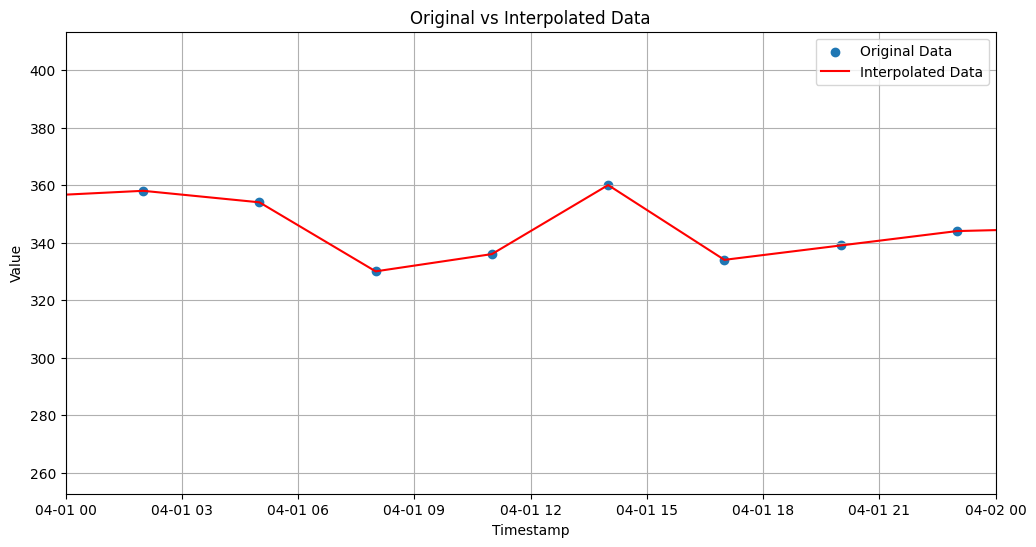

In [55]:
adm = "York"
plotting = restricted_data[restricted_data['adm2_name'] == adm]

# Plotting for visualization
print('ADM2: ', adm)
print('State: ', adm2_json[adm2_json['name_2'] == adm]['name_1'].values[0])

init.plt.figure(figsize=(12, 6))
init.plt.scatter(plotting['timestamp'], plotting['rtt_mean_norm'], label='Original Data')
init.plt.plot(interpolated_data['timestamp'], interpolated_data[adm], 'r-', label='Interpolated Data')
init.plt.xlabel('Timestamp')
init.plt.ylabel('Value')
trim_start = init.pd.to_datetime('2024-04-01')
trim_end = init.pd.to_datetime('2024-04-02')
init.plt.xlim(trim_start, trim_end)
init.plt.title('Original vs Interpolated Data')
init.plt.legend()
init.plt.grid(True)
init.plt.show()

In [ ]:
def area_finder(latency_area, latency_state, adm2_list):
    # ACT Case
    if latency_state == 'Australian Capital Territory':
        adm2_list = adm2_list[:111]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx
        return None
    
    # NSW Case
    elif latency_state == 'New South Wales':
        adm2_list = adm2_list[110:309]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 110
        return None
    
    # NT Case
    elif latency_state == 'Northern Territory':
        adm2_list = adm2_list[308:404]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 308
        return None
    
    # QLD Case
    elif latency_state == 'Queensland':
        adm2_list = adm2_list[403:875]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 403
        return None
    
    # SA Case
    elif latency_state == 'South Australia':
        adm2_list = adm2_list[874:1002]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 874
        return None
    
    # TAS Case
    elif latency_state == 'Tasmania':
        adm2_list = adm2_list[1000:1039]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 1002
        return None
    
    # VIC Case
    elif latency_state == 'Victoria':
        adm2_list = adm2_list[1038:1247]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 1038
        return None
    
    # WA Case
    else:
        adm2_list = adm2_list[1246:]
        for json_idx in range(len(adm2_list)):
            if adm2_list[json_idx] == latency_area:
                return json_idx + 1246
        return None

for idx in init.tqdm(range(len(latency_data))):

    # if no data for an area, skip it
    if init.np.isnan(latency_data.iloc[idx]['rtt_mean_norm']):
        continue

    # find the corresponding adm2 area in the json file
    # insert finding function here, maybe include some skips to state level
    area = area_finder(latency_data.iloc[idx]['adm2_name'], latency_data.iloc[idx]['adm1_name'], list(adm2_json['name_2']))
    if area == None:
        if latency_data.iloc[idx]['adm2_name'] == 'Saibai':
            continue
        else:
            print(f"Area not found: {idx}, {latency_data.iloc[idx]['adm1_name']}, {latency_data.iloc[idx]['adm2_name']}")
            continue

    # Update mean latency for that
    if init.pd.isna(adm2_json.at[area, 'Count']):
            adm2_json.at[area, 'Count'] = 0
            adm2_json.at[area, 'Sum Latency'] = 0
            adm2_json.at[area, 'Sum Variance'] = 0

    adm2_json.at[area, 'Count'] += 1
    adm2_json.at[area, 'Sum Latency'] += latency_data.iloc[idx]['rtt_mean_norm']
    adm2_json.at[area, 'Sum Variance'] += latency_data.iloc[idx]['rtt_variance_norm']


adm2_json['Mean Latency'] = adm2_json['Sum Latency'] / adm2_json['Count']
adm2_json['Mean Standard Deviation'] = init.np.sqrt(adm2_json[area]['Sum Variance']) / adm2_json['Count']

In [ ]:
adm2_json.to_file('test.geojson', driver='GeoJSON')